# Project: Data Engineering

## Task I - Extract data

Extract the data from your source. You can use any mechanism you like for extraction except for manual downloading. It must be done either in code or in an process that is able to be automated. For example you should consider using Airflow or Kafka type batch or streaming solutions. If you prefer to simply code this in Jupyter notebooks that is acceptable as well.
You should choose a file format to stage your data prior to transform/load steps.

**Notes:**
- RECOGNITION SHEET (DATA PULLED FOR CLIENT INVOICING, ETC. - This is a Google Sheet data pulled out as a CSV)
- CATS DATA:
  - JOB ORDER DATA (This is all the job order data in the The Restaurant Zone's ATS/Applicant Tracking System used by Recruiters)
  - COMPANY DATA (This is all the companie data in the The Restaurant Zone's ATS/Applicant Tracking System used by Recruiters

###RECOGNITION SHEET DATA

In [4]:
import pandas as pd
from google.colab import auth
auth.authenticate_user()
import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

spreadsheet_url = 'https://docs.google.com/spreadsheets/d/13PxKnqM5XQKB-rJdJl-HlzSZZnV-N21MeB-7yXcajfQ/edit?pli=1&gid=159911692#gid=159911692'
sheet_name = 'Form Responses 1'

# Open the spreadsheet
worksheet = gc.open_by_url(spreadsheet_url).worksheet(sheet_name)

# Get all values from the sheet
data = worksheet.get_all_values()

# Convert to a Pandas DataFrame
df = pd.DataFrame(data[1:], columns=data[0])

# Removing the last 4 columns from the dataframe 'df'
df = df.iloc[:, :-4]

# Now you can work with the DataFrame 'df'
print(df.head())

# You can save it to a CSV file for staging
df.to_csv('extracted_data.csv', index=False)

            Timestamp                    Email Address               Name  \
0  12/23/2022 2:33:59     sherry@therestaurantzone.com       Sherry Brown   
1    1/4/2023 3:30:35    whitney@therestaurantzone.com  Whitney Armistead   
2    1/7/2023 5:01:37        max@therestaurantzone.com   Maximilian Vlach   
3  12/23/2022 2:36:53     sherry@therestaurantzone.com       Sherry Brown   
4    1/4/2023 1:00:35  jacquelyn@therestaurantzone.com    Jacquelyn Simon   

     Candidate Name Candidate start date  \
0  Matthew Stanford             1/2/2023   
1       Metz Rogers             1/2/2023   
2      Rodney Smith             1/2/2023   
3      Daniel Munoz             1/3/2023   
4    Jeanette Ellis             1/3/2023   

  Candidate Annual Salary\n\nPlease follow this format 1000. Example if your billing is $4K, then you'd insert 4000, NOT $4000, 4K, "4,000", four thousand. (numeric without special characters)  \
0                                         $75,000.00                        

In [5]:
# Completeness check is good for recognition sheet.

# Assuming df is your DataFrame containing the recognition sheet data
total_rows = len(df)
print(f"Total number of rows in the recognition sheet data: {total_rows}")

Total number of rows in the recognition sheet data: 463


In [6]:
# prompt: liat name of columns for df

print(df.columns)

Index(['Timestamp', 'Email Address', 'Name', 'Candidate Name',
       'Candidate start date',
       'Candidate Annual Salary\n\nPlease follow this format 1000. Example if your billing is $4K, then you'd insert 4000, NOT $4000, 4K, "4,000", four thousand. (numeric without special characters)',
       'Client (Company Name)', 'Job Order #ID',
       'Billable Placement amount due  (IF REPLACEMENT, PLEASE PUT $0 FOR AMOUNT)\n\nPlease follow this format 1000. Example if your billing is $4K, then you'd insert 4000, NOT $4000, 4K, "4,000", four thousand. (numeric without special characters) ',
       'Branch Name',
       'When did this candidate leave? (Optional) Only fill out if candidate left job. Can be edited after form submission.',
       'Is this candidate a replacement?',
       'Placement explanation/instructions (Optional)',
       'Account Manager (email)', 'Candidate Position', 'Candidate Source',
       'Month', 'Year', 'Quarter Stamp', 'Weekly Stamp',
       'Did this candida

### CATS DATA

Pulled for Job Orders and Companies


####Pulling Company data

In [7]:
import requests
import pandas as pd

api_key = 'a245c5b105407219bbcdadfdc093a455'
# Define the API endpoint for companies
url = "https://api.catsone.com/v3/companies"

# Set up headers for the request
headers = {
    'Authorization': f'Token {api_key}',
    'Content-Type': 'application/json',
    'User-Agent': 'Mozilla/5.0'
}

# Set up parameters for pagination
params = {
    'per_page': 100,  # Number of results per page (max is 100)
    'page': 1         # Start at page 1
}

all_companies = []  # List to store all companies

# Paginate through all pages
while True:
    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        data = response.json()

        # Extract companies data
        companies = data['_embedded']['companies']
        all_companies.extend(companies)  # Add the companies to the list

        # Check if there are more pages
        if '_links' in data and 'next' in data['_links']:
            params['page'] += 1  # Increment the page number
        else:
            break  # Exit loop if no more pages
    else:
        print(f"Failed to fetch data: {response.status_code}")
        break

# Convert the results to a DataFrame
df_companies = pd.DataFrame(all_companies)
df_companies.to_csv('companies_data.csv', index=False)  # Save the DataFrame as CSV

# Print the first few rows of the DataFrame
print(df_companies.head())


         id  owner_id                name website  \
0  21531676    557926   Catfish Charlie's           
1  21926379    557920         14 & Hudson           
2  21926382    557920          264 Fresco           
3  21926385    557920              5 Guys           
4  21926388    557920  Penn Station, Inc.           

                                             address country_code  \
0  {'street': '', 'city': '', 'state': '', 'posta...         None   
1  {'street': '457 Piermont Avenue', 'city': 'Pie...         None   
2  {'street': '264 Carlsbad Village Drive', 'city...         None   
3  {'street': '', 'city': '', 'state': '', 'posta...         None   
4  {'street': '', 'city': 'Crestview Hills', 'sta...         None   

                                              phones  entered_by_id  \
0  {'primary': None, 'secondary': None, 'fax': None}         557917   
1  {'primary': None, 'secondary': None, 'fax': None}         557920   
2  {'primary': '17605292882', 'secondary': None, ... 

In [8]:
# This passes the completeness check for 2000 companies in the Databse and ATS.

import pandas as pd

# Load the CSV file into a pandas DataFrame
df_companies = pd.read_csv('companies_data.csv')

# Convert the 'date_created' column to datetime objects (if it's not already)
df_companies['date_created'] = pd.to_datetime(df_companies['date_created'])

# Find the minimum and maximum dates in the 'date_created' column
min_date = df_companies['date_created'].min()
max_date = df_companies['date_created'].max()

print(f"The date range for 'date_created' is from {min_date} to {max_date}")

The date range for 'date_created' is from 2021-10-15 21:33:41+00:00 to 2024-10-21 22:45:10+00:00


In [9]:
print(df_companies.columns)

Index(['id', 'owner_id', 'name', 'website', 'address', 'country_code',
       'phones', 'entered_by_id', 'social_media_urls', 'notes', 'is_hot',
       'key_technologies', 'billing_contact_id', 'date_created',
       'date_modified', 'status_id', 'user_groups', '_links', '_embedded'],
      dtype='object')


In [10]:
# Create a copy of df_companies to avoid modifying the original DataFrame
df_company_active = df_companies.copy()

# Add a new column 'Active?' and set it to 1 for status_id 6215461, otherwise 0
df_company_active['Active?'] = (df_company_active['status_id'] == 6215461).astype(int)

In [11]:
import sqlite3
conn = sqlite3.connect('company_data.db')
df_company_active.to_sql('df_company_active', conn, if_exists='replace', index=False)
curr = conn.cursor()

company = pd.read_sql_query('select id, owner_id, "Active?", name from df_company_active',conn)
company

,id,owner_id,Active?,name
0,21531676,557926,0,Catfish Charlie's
1,21926379,557920,0,14 & Hudson
2,21926382,557920,0,264 Fresco
3,21926385,557920,0,5 Guys
4,21926388,557920,0,"Penn Station, Inc."
...,...,...,...,...
1996,22725145,585911,1,Working Title Food Group
1997,22833590,585911,0,Local Favorite Restaurants
1998,22846450,585911,0,ARC Group Inc.
1999,22819393,586382,0,McDonald's


####Pulling Data for Job Orders

In [12]:
import requests
import pandas as pd

api_key = 'a245c5b105407219bbcdadfdc093a455'
# Define the API endpoint for job orders
url = "https://api.catsone.com/v3/jobs"

# Set up headers for the request
headers = {
    'Authorization': f'Token {api_key}',
    'Content-Type': 'application/json',
    'User-Agent': 'Mozilla/5.0'
}

# Set up parameters for pagination
params = {
    'per_page': 100,  # Number of results per page (max is 100)
    'page': 1         # Start at page 1
}

all_jobs = []  # List to store all job orders

# Paginate through all pages
while True:
    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        data = response.json()

        # Extract job orders data
        jobs = data['_embedded']['jobs']
        all_jobs.extend(jobs)  # Add the jobs to the list

        # Check if there are more pages
        if '_links' in data and 'next' in data['_links']:
            params['page'] += 1  # Increment the page number
        else:
            break  # Exit loop if no more pages
    else:
        print(f"Failed to fetch data: {response.status_code}")
        break

# Convert the results to a DataFrame
df_jobs = pd.DataFrame(all_jobs)
df_jobs.to_csv('jobs_data.csv', index=False)  # Save the DataFrame as CSV

# Print the first few rows of the DataFrame
print(df_jobs.head())


         id              title  \
0  15228585  Assistant Manager   
1  15228606    General Manager   
2  15228609  Assistant Manager   
3  15228612  Assistant Manager   
4  15228615     Executive Chef   

                                            location country_code  \
0  {'city': 'Springdale', 'state': 'AR', 'postal_...         None   
1  {'city': 'Monroe', 'state': 'LA', 'postal_code...         None   
2  {'city': 'Sprinfield', 'state': 'AR', 'postal_...         None   
3  {'city': 'Marshall', 'state': 'TX', 'postal_co...         None   
4  {'city': 'Hubertus', 'state': 'WI', 'postal_co...         None   

                      description notes  recruiter_id  sourcer_id  owner_id  \
0  No description from conversion                 NaN         NaN         0   
1  No description from conversion                 NaN         NaN         0   
2  No description from conversion                 NaN         NaN         0   
3  No description from conversion            585921.0         Na

In [13]:
print(df_jobs.columns)

Index(['id', 'title', 'location', 'country_code', 'description', 'notes',
       'recruiter_id', 'sourcer_id', 'owner_id', 'category_name', 'is_hot',
       'start_date', 'salary', 'max_rate', 'duration', 'openings',
       'external_id', 'company_id', 'department_id', 'contact_id', 'status_id',
       'pipeline_workflow_id', 'type', 'portal_hidden', 'is_published',
       'date_created', 'date_modified', 'user_groups', 'remote_type', '_links',
       '_embedded'],
      dtype='object')


In [14]:
# Transforming df_jobs to DataFrame
job_volume_by_company = df_jobs.groupby('company_id')['company_id'].count().reset_index(name='job volume')
print(job_volume_by_company)

     company_id  job volume
0      21531676           5
1      21531718           7
2      21537688           7
3      21604945           9
4      21605362           7
..          ...         ...
864    22966003           1
865    22966019           3
866    22966117           1
867    22968355           2
868    22972062           2

[869 rows x 2 columns]


In [15]:
import requests
import pandas as pd

BASE_URL = "https://api.catsone.com/v3/users"

# Set up the authorization headers
headers = {
    "Authorization": f"Token a245c5b105407219bbcdadfdc093a455",
    "Content-Type": "application/json"
}

# Function to fetch users
def get_users():
    response = requests.get(BASE_URL, headers=headers)

    if response.status_code == 200:
        return response.json()  # Parse the JSON response
    else:
        print(f"Error: {response.status_code}")
        return None

# Fetch the user details
users_data = get_users()

# Initialize a list to store the user data
user_list = []

# If data is retrieved successfully, extract user information
if users_data:
    # Only focus on '_embedded' section containing 'users'
    for user in users_data['_embedded']['users']:
        user_id = user.get('id', 'No User ID')
        first_name = user.get('first_name', 'No First Name')
        last_name = user.get('last_name', 'No Last Name')

        # Append the user info as a dictionary
        user_list.append({
            'User ID': user_id,
            'First Name': first_name,
            'Last Name': last_name
        })

    # Create a DataFrame from the list
    user_df = pd.DataFrame(user_list)

    # Display the DataFrame
    print(user_df)


    User ID       First Name    Last Name
0    557923  Restaurant Zone      (Admin)
1    561859          Raghdah       Alawis
2    567126             Jack      Albrect
3    589849           Jaclyn    Alexander
4    586382           Janine      Alfonso
5    561880           Alicia      Ambrose
6    567147             Gage       Andres
7    588904             Olga     Antonova
8    561856          Whitney    Armistead
9    571949          Scarlet      Banegas
10   589529          Russell       Barlow
11   565501         Cromwell      Barredo
12   565912         Carolina       Basave
13   590119             Bill       Behany
14   567117            Kenny    Benavides
15   585327         Benjamin       Berger
16   567153         Jonathan         Bing
17   585918        Elizabeth   Blankstein
18   562036             Ella     Blasabas
19   587979            Wendy       Branch
20   570375           Austin        Breen
21   585916            Scott      Brenner
22   567183            Tanya    Br

Reading the company_id and owner names from .csv file

In [16]:
creds, _ = default()

gc = gspread.authorize(creds)

spreadsheet_url = 'https://docs.google.com/spreadsheets/d/12wslmQlOY5OXwbbCMHxbdVDQMJLo35N27THkuVW-Az0/edit?usp=drive_link'
sheet_name = 'Owner_CompanyID'

# Open the spreadsheet
worksheet = gc.open_by_url(spreadsheet_url).worksheet(sheet_name)

# Get all values from the sheet
data = worksheet.get_all_values()

# Convert to a Pandas DataFrame
name_df = pd.DataFrame(data[1:], columns=data[0])

# Showing the first few rows
print(name_df.head())

         Owner        ID
0  Jennifer C.  22579022
1  Jennifer C.  22565732
2  Greggory S.  21780250
3   Garrett R.  22962417
4  Greggory S.  22968355


## Task II - Load

In [17]:
conn = sqlite3.connect('company_data.db')
df.to_sql('df', conn, if_exists='replace', index=False)
job_volume_by_company.to_sql('job_volume_by_company', conn, if_exists='replace', index=False)
user_df.to_sql('user_df', conn, if_exists='replace', index=False)
name_df.to_sql('name_df', conn, if_exists='replace', index=False)
conn.close()

Testing if all the datframe were into the company_data.db Database

In [18]:
conn = sqlite3.connect('company_data.db')
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("Dataframe names in company_data.db:")
for table in tables:
  print(table[0])

conn.close()

Dataframe names in company_data.db:
df_company_active
df
job_volume_by_company
user_df
name_df


## Task III - Transform

May be done prior to Loading
Your data must be transformed in some way prior to loading. Adding new computed columns, transforming text variables, aggregating, sampling etc.

In [19]:
# Rename columns
df = df.rename(columns={
    "Candidate Annual Salary\n\nPlease follow this format 1000. Example if your billing is $4K, then you'd insert 4000, NOT $4000, 4K, \"4,000\", four thousand. (numeric without special characters)": "Candidate Annual Salary"
})

# Fix the problematic column name by escaping internal quotes
original_column_name = "Billable Placement amount due  (IF REPLACEMENT, PLEASE PUT $0 FOR AMOUNT)\n\nPlease follow this format 1000. Example if your billing is $4K, then you'd insert 4000, NOT $4000, 4K, \"4,000\", four thousand. (numeric without special characters) "
new_column_name = "Billable Placement amount due"

# Rename the problematic column
df.columns = [new_column_name if col == original_column_name else col for col in df.columns]

# Preprocess columns
for col in ['Candidate Annual Salary', 'Billable Placement amount due']:
    if col in df.columns:
        # Remove currency symbols, commas, and convert to numeric
        df[col] = df[col].astype(str).str.replace('[\$,]', '', regex=True).str.strip()
        df[col] = pd.to_numeric(df[col], errors='coerce')
    else:
        print(f"Column '{col}' not found. Please check the column name.")

# Convert columns to appropriate types
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['Candidate start date'] = pd.to_datetime(df['Candidate start date'], errors='coerce')

# Remove duplicates and group
df_unique = df.drop_duplicates(subset=['Job Order #ID'], keep='first')

# Filtering out where "Client Paid? (Collection Use only)" for 'Y'
df_unique = df_unique[df_unique['Client Paid? (Collection Use only)\n\nY/N'] != 'N']

# Aggregate based on 'Name'
df_grouped = df_unique.groupby('Account Manager (email)').agg({
    'Billable Placement amount due': 'sum'  # Using the renamed column
}).reset_index()

# Print the grouped DataFrame in Descending Order
df_grouped = df_grouped.sort_values(by='Billable Placement amount due', ascending=False)
print(df_grouped.head())


                Account Manager (email)  Billable Placement amount due
3  greggory.skoch@therestaurantzone.com                     1036808.50
0         allison@therestaurantzone.com                     1012981.69
6           sales@therestaurantzone.com                      349221.09
4    jenniferchen@therestaurantzone.com                      156815.00
1       contactus@therestaurantzone.com                       91935.00


Looking up the column names from the three dataframes: job_volume_by_company, user_df, df_company_active

In [20]:
print(job_volume_by_company.columns)
print(user_df.columns)
print(df_company_active.columns)

Index(['company_id', 'job volume'], dtype='object')
Index(['User ID', 'First Name', 'Last Name'], dtype='object')
Index(['id', 'owner_id', 'name', 'website', 'address', 'country_code',
       'phones', 'entered_by_id', 'social_media_urls', 'notes', 'is_hot',
       'key_technologies', 'billing_contact_id', 'date_created',
       'date_modified', 'status_id', 'user_groups', '_links', '_embedded',
       'Active?'],
      dtype='object')


Joining Tables

In [21]:
conn = sqlite3.connect('company_data.db')

# Perform the left joins
query = """
SELECT
    *
FROM
    df_company_active
LEFT JOIN
    name_df ON df_company_active.id = name_df.'id'
LEFT JOIN
    job_volume_by_company ON df_company_active.id = job_volume_by_company.company_id
"""

final_aggregated_df = pd.read_sql_query(query, conn)
conn.close()

print(final_aggregated_df.head())

         id  owner_id                name website  \
0  21531676    557926   Catfish Charlie's    None   
1  21926379    557920         14 & Hudson    None   
2  21926382    557920          264 Fresco    None   
3  21926385    557920              5 Guys    None   
4  21926388    557920  Penn Station, Inc.    None   

                                             address country_code  \
0  {'street': '', 'city': '', 'state': '', 'posta...         None   
1  {'street': '457 Piermont Avenue', 'city': 'Pie...         None   
2  {'street': '264 Carlsbad Village Drive', 'city...         None   
3  {'street': '', 'city': '', 'state': '', 'posta...         None   
4  {'street': '', 'city': 'Crestview Hills', 'sta...         None   

                                              phones  entered_by_id  \
0  {'primary': None, 'secondary': None, 'fax': None}         557917   
1  {'primary': None, 'secondary': None, 'fax': None}         557920   
2  {'primary': '17605292882', 'secondary': None, ... 

Data Preprocessing

In [22]:
final_aggregated_df['job volume'] = final_aggregated_df['job volume'].fillna(0)

# Removing first column
final_aggregated_df = final_aggregated_df.iloc[:, 1:]
print(final_aggregated_df.head())

   owner_id                name website  \
0    557926   Catfish Charlie's    None   
1    557920         14 & Hudson    None   
2    557920          264 Fresco    None   
3    557920              5 Guys    None   
4    557920  Penn Station, Inc.    None   

                                             address country_code  \
0  {'street': '', 'city': '', 'state': '', 'posta...         None   
1  {'street': '457 Piermont Avenue', 'city': 'Pie...         None   
2  {'street': '264 Carlsbad Village Drive', 'city...         None   
3  {'street': '', 'city': '', 'state': '', 'posta...         None   
4  {'street': '', 'city': 'Crestview Hills', 'sta...         None   

                                              phones  entered_by_id  \
0  {'primary': None, 'secondary': None, 'fax': None}         557917   
1  {'primary': None, 'secondary': None, 'fax': None}         557920   
2  {'primary': '17605292882', 'secondary': None, ...         557920   
3  {'primary': None, 'secondary': None, 'f

Adding the final_aggregated_df into the company_data.db

In [23]:
conn = sqlite3.connect('company_data.db')
final_aggregated_df.to_sql('final_aggregated_df', conn, if_exists='replace', index=False)
conn.close()

Selecting relevant columns from the final database: name, job volume, First Name and Last Name concatenated as Account Owner

In [24]:
conn = sqlite3.connect('company_data.db')

query = """
SELECT
  ID,
  name,
  "job volume",
  "Owner" AS Account_Owner
FROM
  final_aggregated_df
ORDER BY
  "job volume" DESC;
"""

relevant_df = pd.read_sql_query(query, conn)
conn.close()

print(relevant_df.head())

         ID                               name  job volume Account_Owner
0  22104318        Dave & Busters + Main Event       134.0   Greggory S.
1  22183190                      Steak & Shake       100.0    Allison H.
2  22731930                 Zaxby's - CKN, Inc        59.0   Greggory S.
3  21677494  Wendy's - Heritage Partners Group        50.0   Greggory S.
4  21605563                   Westgate Resorts        48.0   Greggory S.


## Task IV - Serve

Serve your data for some type of analytics.
Generate simple graphs or tables of your data. This could be as simple as a sql query that groups and counts data.
For those with data mining experience you may consider training a model with your data.

In [25]:
import plotly.express as px

# Dashboard for last year (Example for one timeframe)
import datetime as dt

# Filter for the last year
today = dt.datetime.today()
last_year = today - pd.DateOffset(years=1)

df_last_year = df_unique[df_unique['Timestamp'] >= last_year]

# Group by 'Name' and aggregate
df_year_grouped = df_last_year.groupby('Account Manager (email)').agg({
    'Billable Placement amount due': 'sum',
}).reset_index().sort_values(by='Billable Placement amount due', ascending=False)

# Plotting
fig = px.bar(df_year_grouped, x='Account Manager (email)', y='Billable Placement amount due', title='Billable Placement Amount in Last Year')
fig.show()


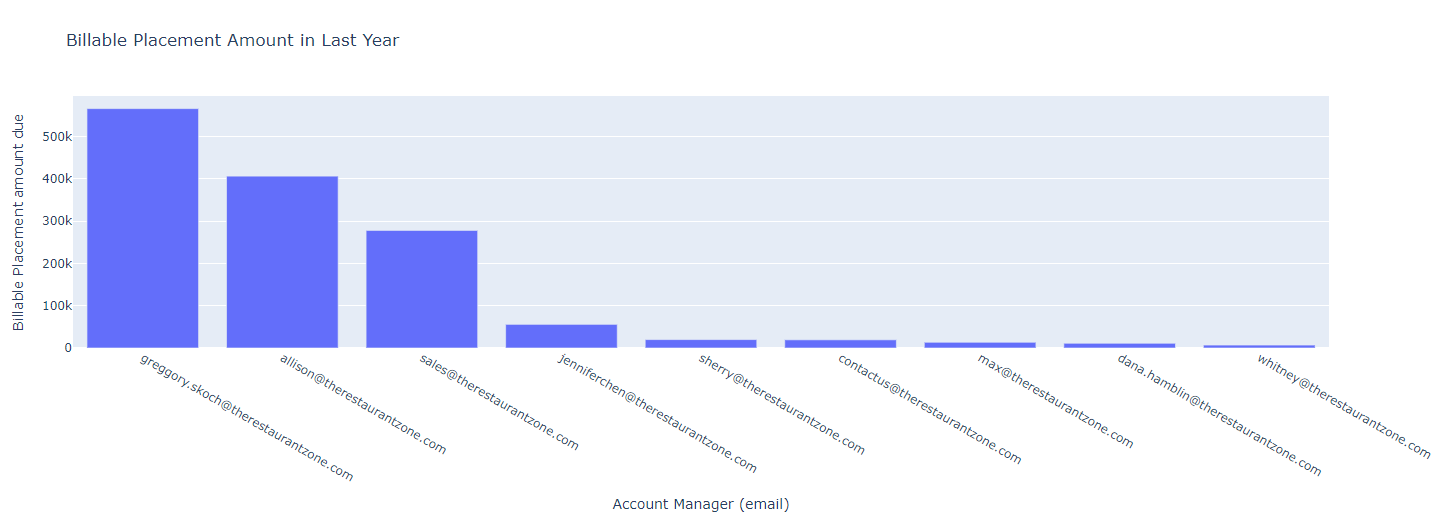

Creating a Leaderboard for Account Manager and Job Volume

In [26]:
import plotly.express as px
import plotly.graph_objects as go

# Step 1: Aggregate the job volumes per Account Owner
aggregated_df = relevant_df.groupby('Account_Owner', as_index=False)['job volume'].sum()

# Step 2: Create a horizontal bar chart with the total job volume for each Account Owner
fig = go.Figure(data=[go.Bar(
    x=aggregated_df['job volume'],  # Total job volume
    y=aggregated_df['Account_Owner'],
    text=aggregated_df['job volume'],  # Display total job volume as text
    textposition='auto',
    orientation='h',  # Horizontal orientation
    marker_color='rgba(55, 128, 191, 0.7)',
    marker_line_color='rgba(55, 128, 191, 1.0)',
    marker_line_width=1.5
)])

# Step 3: Update layout for sorting and appearance
fig.update_layout(
    title='Leaderboard: Account Owners by Total Job Volume (Sorted)',
    xaxis_title='Job Volume',
    yaxis_title='Account Owner',
    height=1000,  # Adjust height
    width=1200,   # Adjust width
    yaxis={'categoryorder': 'total ascending'},  # Sort bars by total job volume
)

fig.show()





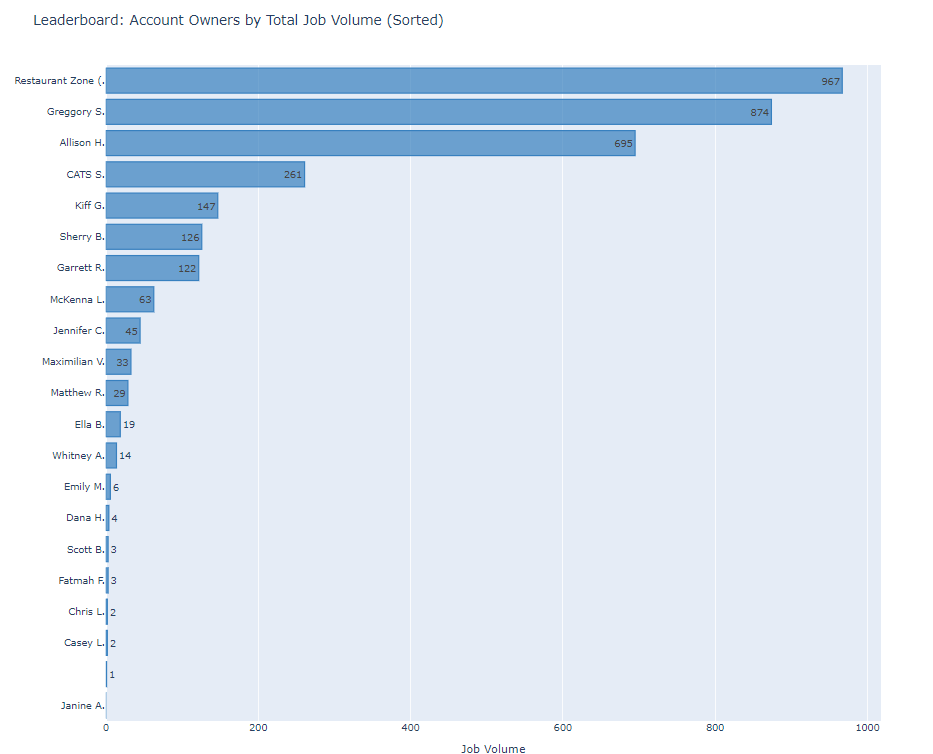

In [27]:
# You can create more visualizations by exploring different chart types
# and using other columns in your relevant_df DataFrame.

# Example: Pie chart of job volume distribution per account owner
# (if you have more categories, pie chart might not be ideal)
fig_pie = px.pie(relevant_df, values='job volume', names='Account_Owner', title='Job Volume Distribution by Account Owner')
fig_pie.show()


# Example: Table view with styling
fig_table = go.Figure(data=[go.Table(
    header=dict(values=list(relevant_df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[relevant_df.ID ,relevant_df.name, relevant_df['job volume'], relevant_df.Account_Owner],
               fill_color='lavender',
               align='left'))
])

fig_table.update_layout(title='Leaderboard: Account Owners by Job Volume (Table View)')
fig_table.show()

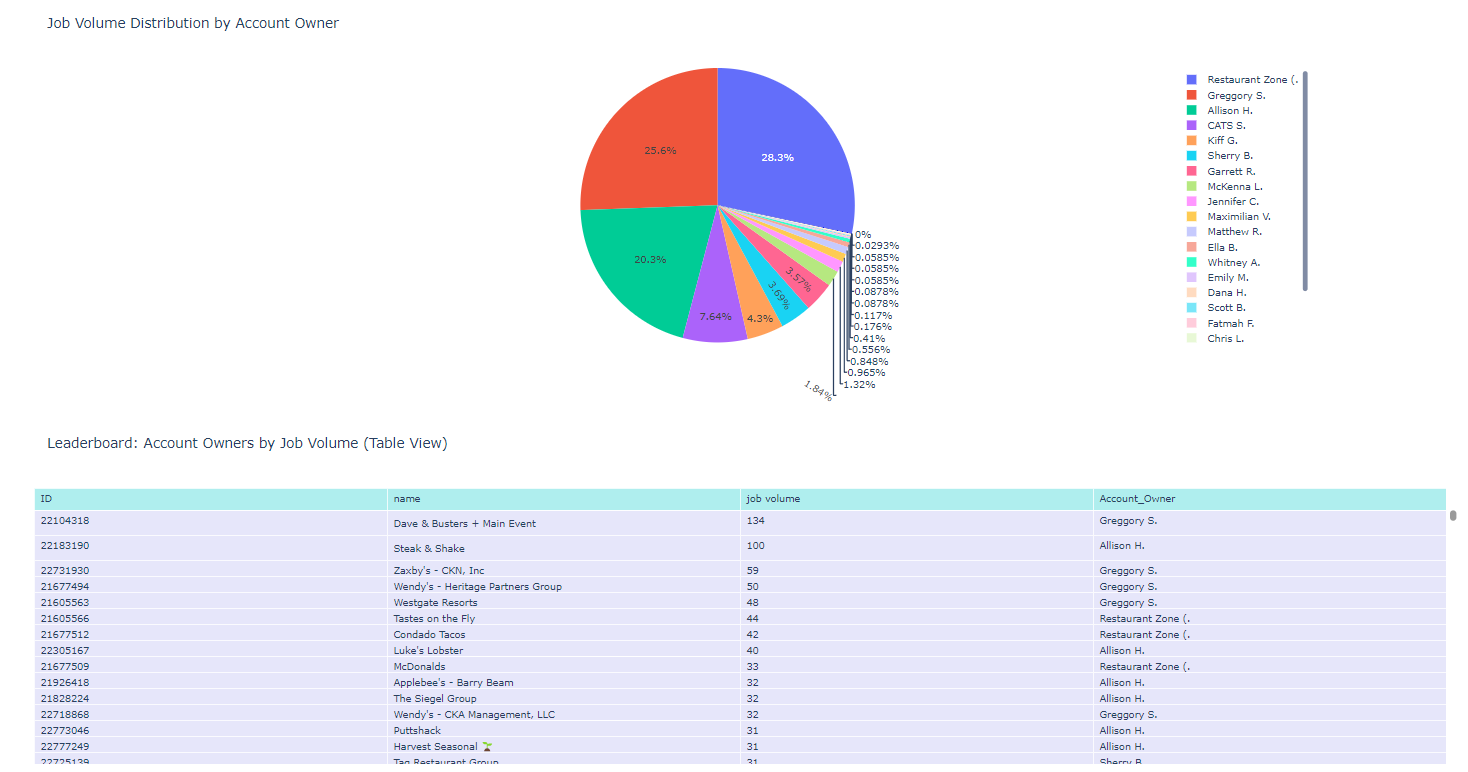

## Task V - Document and Explain your project

Please create workflow diagrams as well as detailed explanations around your project. Use these details to build a final presentation to explain your project to your fellow students. Look to the final project submission for details on expected submission requirements.



1.   Start: The process begins.

2.   Gather Data:
  *   Data is gathered, which includes receiving NDA, Data, and API requests from The Restaurant Zone.

3.   Data Sources: The gathered data is divided into four main sources:
  *   Recognition Sheet Data
  *   Jobs Order
  *   CATS Data
  *   Company IDs and Owner Names from a .csv file

4.   Data Extraction: For each data source, the workflow checks if any data is missing (NA check):
  *   If there is missing data (NA), a "Check" step is performed. Otherwise,data is extracted from each source.

5.   Data Verification: After data extraction, each source undergoes a verification step to ensure accuracy.

6.   Convert to Dataframe: Once verified, the data is converted into dataframes for further use.

7.   Create Database: After converting all data sources into dataframes, they are combined into a central database.

8.   Data Cleaning & Combining: The company data is cleaned and combined into a final form.

9.   Data Visualization: Once cleaned and combined, the data is used for visualization.

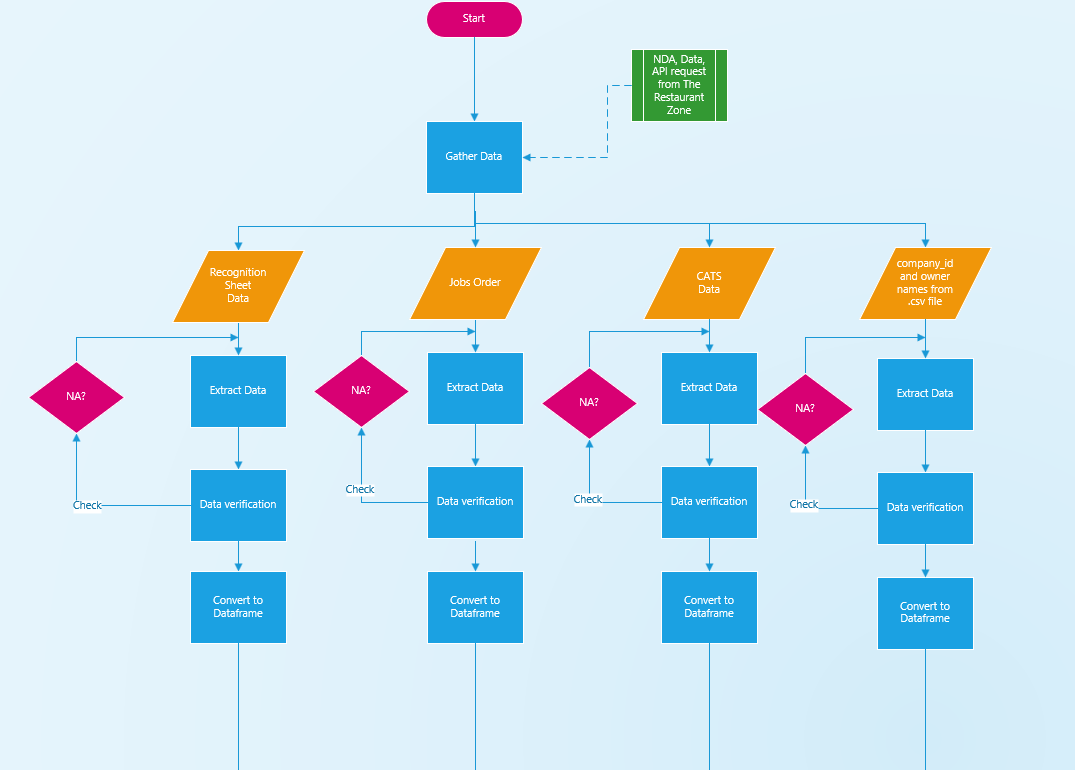

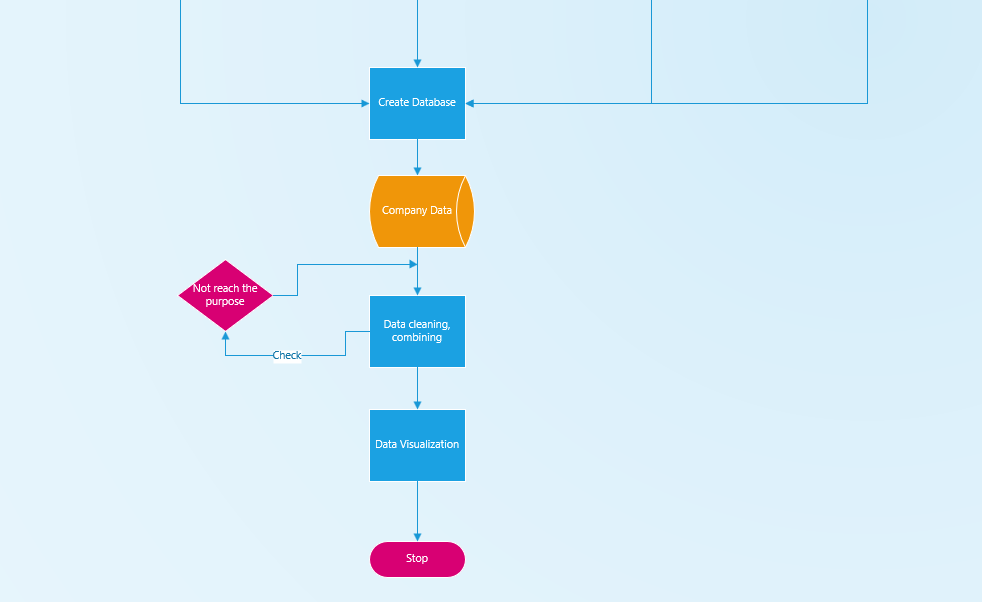

This is the end of the document